# Skin-NonSkin

In [2]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [3]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/skin_nonskin(245057,3).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)

x_test = x_tr[int(x_tr.shape[0] * 0.8):, :]
y_test = y_tr[int(x_tr.shape[0] * 0.8):]
y_tr = y_tr[:int(x_tr.shape[0] * 0.8)]
x_tr = x_tr[: int(x_tr.shape[0] * 0.8), :]

data_name = 'skin_nonskin'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 2] = -1
y_test[y_test == 2] = -1
dim, num = x_tr.shape

print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 196045
of features: 3
skin_nonskin


## K-Means cluster centers

In [7]:
ind_num = 20
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [8]:
with open('../plots/vi_vs_svi_class/'+ data_name +'_title.txt', 'w') as f:
    title = 'skin\_nonskin dataset, ' + 'n = ' + str(num) + ', d = ' + str(dim) + ', m = ' + str(ind_num)
    f.write(title)

In [9]:
cov_params = np.array([5., 2., .3])

## SVM
Here we train an SVM for reference

In [19]:
svm = SVC(C=1e0)
svm.fit(x_tr.T, y_tr)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [22]:
predicted = svm.predict(x_test.T)
accuracy_score(y_test, predicted)

0.99457275769199383

## svi-L-BFGS-B-c method

In [18]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [19]:
opts = {'mode': 'full', 'maxiter': 100, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 5.   2.   0.3  0.   0. ]
Hyper-parameters at iteration 1 : [ 4.99979475  2.04104992  0.29998807  0.128254   -0.3775251 ]
Hyper-parameters at iteration 2 : [ 5.04869467  1.93221015  0.1457531   0.61011769 -1.74956675]
Hyper-parameters at iteration 3 : [ 5.07817104  1.93178787  0.07604555  1.0185674  -2.41632599]
Hyper-parameters at iteration 4 : [ 5.14593629  1.97078348  0.25075945  2.0428713  -4.02890188]
Hyper-parameters at iteration 5 : [ 5.17173546  1.94061281  0.22766717  2.35129097 -4.50065535]
Hyper-parameters at iteration 6 : [ 5.21617241  1.81677039  0.1831105   2.89215852 -5.32972502]
Hyper-parameters at iteration 7 : [ 5.23802869  1.70738981  0.17482503  3.16080889 -5.75755204]
Hyper-parameters at iteration 8 : [ 5.26722608  1.47869212  0.18778388  3.5097189  -6.34826654]
Hyper-parameters at iteration 9 : [ 5.28157281  1.20112134  0.22018018  3.72457899 -6.77934246]
Hyper-parameters at iteration 10 : [ 5.24182642  0.92314999  0.25829313  3.

In [20]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

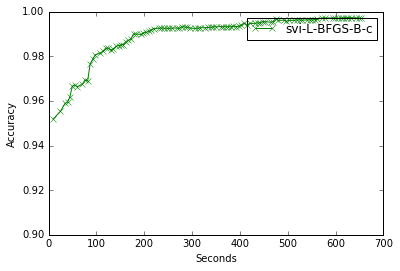

In [21]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [22]:
svi_y_lst[-1]

0.99693952501428218

## vi-means-c method
Подбор числа пересчетов

In [78]:
maxfuns = [5, 10, 15, 20]
results = []
for maxfun in maxfuns:
    print(maxfun)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    vi_gp = GPC(model_covariance_obj, method='vi')
    opts = {'maxfun':maxfun, 'mydisp': True, 'num_updates':3}
    results.append(vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=7))
    print()

5
Hyper-parameters at iteration 0 : [ 5.   2.   0.3]
Hyper-parameters at iteration 1 : [ 10.50989908   1.95756164   0.29381552]
Hyper-parameters at iteration 2 : [ 7.78610979  1.82450465  0.01      ]
	Hyper-parameters at outter iteration 0 : [ 7.59514399  1.78864158  0.01      ]
Hyper-parameters at iteration 0 : [ 7.59514399  1.78864158  0.01      ]
Hyper-parameters at iteration 1 : [  1.33665407e+01   1.74886444e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.30704430e+01   1.75118942e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  1.25613971e+01   1.75468222e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.25613971e+01   1.75468222e+00   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.40213595e+01   1.69390498e+00   1.00000000e-02]
Hyper-parameters at iteration 2 : [  1.34777661e+01   1.71672598e+00   1.00000000e-02]
Hyper-parameters at iteration 3 : [  1.33802612e+01   1.72115815e+00   1.00000000e-02]
	Hyper-parameters at outter ite

0
1
2
3


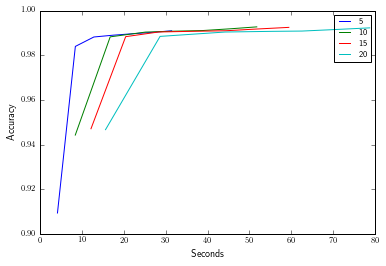

In [79]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(maxfuns)):
    vi_x_lst, vi_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(vi_x_lst[1:], vi_y_lst[1:], label=maxfuns[i])
    print(i)
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

Обучение лучшего варианта

In [21]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': False, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=50)

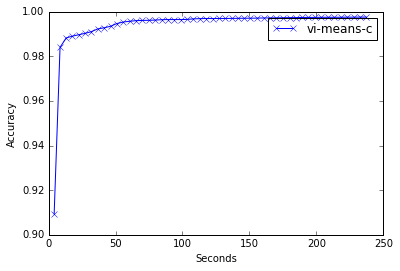

In [24]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1, verbose=False)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [25]:
vi_y_lst[-1]

0.99755162001142572

### Taylor
Подбор числа пересчетов

In [ ]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=50)

In [ ]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_t_x_lst, vi_t_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [31]:
vi_t_y_lst[-1]

0.99838814984085533

### JJ-full
#### Standard

In [10]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'maxiter':50, 'mydisp': True, 'hybrid': False}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Standard mode
Hyper-parameters at iteration 0 : [ 5.   2.   0.3  1.   1. ]
Hyper-parameters at iteration 1 : [ 5.98994834  1.99131823  0.29873482  1.00006521  1.00031274]
Hyper-parameters at iteration 2 : [ 4.42320585  1.48951563  0.01        0.99996446  0.99983811]
Hyper-parameters at iteration 3 : [ 0.43496029  0.76739855  0.01        0.99969691  0.99860896]
Hyper-parameters at iteration 4 : [ 0.33158085  0.58314737  0.01        0.99961894  0.99827866]
Hyper-parameters at iteration 5 : [ 0.58590614  0.57724498  0.01        0.99958828  0.99815343]
Hyper-parameters at iteration 6 : [ 0.53205887  0.50282888  0.01        0.99957042  0.99807914]
Hyper-parameters at iteration 7 : [ 0.48461937  0.47994434  0.01        0.99956904  0.99807666]
Hyper-parameters at iteration 8 : [ 0.47274304  0.48423847  0.01        0.9995723   0.99809589]
Hyper-parameters at iteration 9 : [ 0.47059758  0.48584132  0.01        0.99957383  0.99810719]
Hyper-parameters at iteration 10 : [ 0.46987855  0.48632388  

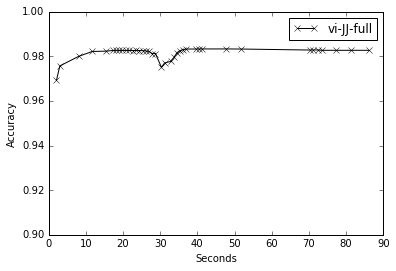

In [11]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_full_x_lst, vi_full_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

#### Hybrid

In [34]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'mydisp': True, 'hybrid': True, 'maxfun':5, 'maxoutiter': 50}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hybrid mode
	Analytic updates number:3
Outter iteration 0
Hyper-parameters at iteration 0 : [ 5.   2.   0.3  1.   1. ]
Hyper-parameters at iteration 1 : [ 5.98994834  1.99131823  0.29873482  1.00006521  1.00031274]
Hyper-parameters at iteration 2 : [ 4.42320585  1.48951563  0.01        0.99996446  0.99983811]
Outter iteration 1
Hyper-parameters at iteration 0 : [ 0.43496029  0.76739855  0.01        0.83879003  3.3363651 ]
Hyper-parameters at iteration 1 : [ 1.43486016  0.7666409   0.01        0.83879875  3.3364018 ]
Hyper-parameters at iteration 2 : [ 1.36534821  0.69191454  0.01        0.83879843  3.3363999 ]
Hyper-parameters at iteration 3 : [ 1.29848357  0.68470518  0.01        0.83879838  3.33639811]
Outter iteration 2
Hyper-parameters at iteration 0 : [ 1.08958272  0.67280513  0.01        2.21666533  4.05478991]
Hyper-parameters at iteration 1 : [ 1.25729517  0.67242828  0.01        2.21668085  4.05480025]
Hyper-parameters at iteration 2 : [ 1.20377345  0.64910418  0.01        2.2

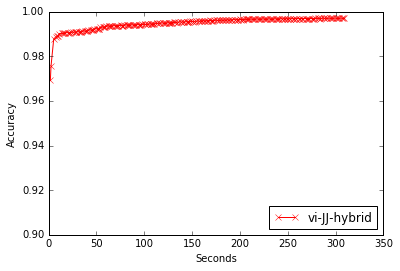

In [35]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_h_x_lst, vi_h_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.ylim([0.9, 1.])
plt.legend(loc=4)
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подбор длины шага

In [7]:
results = []
steps = [1.1, 1., .9, .8, .7, .6, .5]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 10, 'verbose': False, 'batch_size': 2000, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

1.1
1.0
0.9
0.8
0.7
0.6
0.5


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4
5
6


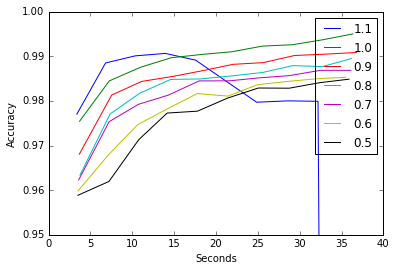

In [9]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.95, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [26]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 50, 'verbose': True, 'batch_size': 2000, 
        'step_rate': 1., 'print_freq':10}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Using AdaDelta optimizer
Iteration  9 :
	Gradient norm 27.7928532712
Iteration  19 :
	Gradient norm 9.42858104017
Iteration  29 :
	Gradient norm 32.5679181279
Iteration  39 :
	Gradient norm 33.4624879395
Iteration  49 :
	Gradient norm 62.8738258768


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


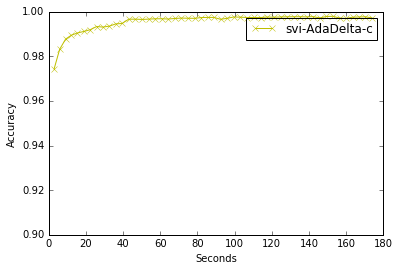

In [27]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [28]:
svi_ad_y_lst[-1]

0.99716395984656814

## Выводы

In [26]:
svi_x_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_svi_x.npy')
svi_y_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_svi_y.npy')
vi_x_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_vi_x.npy')
vi_y_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_vi_y.npy')
vi_t_x_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_vi_t_x.npy')
vi_t_y_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_vi_t_y.npy')
svi_ad_x_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_ad_x.npy')
svi_ad_y_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_ad_y.npy')
# vi_full_x_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_vi_f_x.npy')
# vi_full_y_lst = np.load('../plots/vi_vs_svi_class/old_plots/'+ data_name +'_vi_f_y.npy')

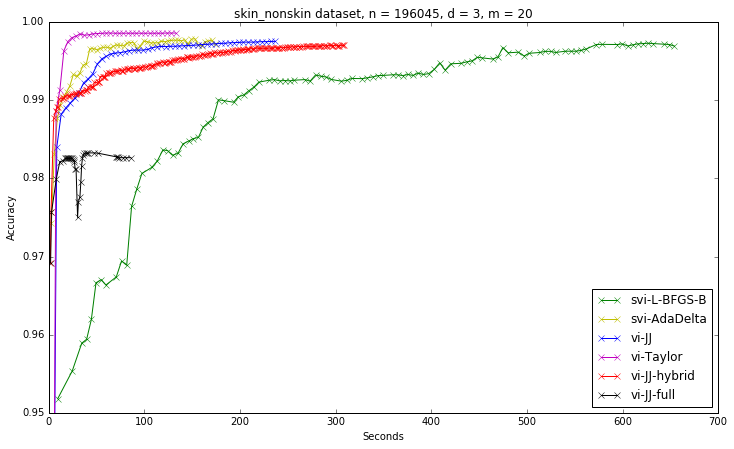

In [38]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-JJ')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.95, 1.])
plt.legend(loc=4)
plt.xlabel('Seconds')
plt.ylabel('Accuracy')
plt.title(data_name+' dataset, n = ' + str(num) + ', d = ' + str(dim) + ', m = '+ str(ind_num))

In [40]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'/svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/ad_y.npy', svi_ad_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_t_x.npy', vi_t_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_t_y.npy', vi_t_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_h_x.npy', vi_h_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_h_y.npy', vi_h_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_f_x.npy', vi_full_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_f_y.npy', vi_full_y_lst)